In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 3007

# training hyperparameters
TRAIN_YEAR = 29
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = True
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
dtrain_val = dataloader.Forcing_Data(
    "./data/data_train_val_CARAVAN.csv",
    record_length=10956,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "./data/data_test_CARAVAN.csv",
    record_length=4017,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [4]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    epochs = min(stats, key=lambda k: stats[k]) + 1
    
    return epochs

In [5]:
def get_final_model(study, dataset, n_catchments =N_CATCHMENTS, epoch_scale = 19/29):

    trial = study.best_trial

    # define model
    model_builder = training_fun.LSTM_model_builder(
        n_catchments, base_length=365, forcing_dim=3
    )

    embedding, decoder = model_builder.define_model(trial)

    embedding, decoder = embedding.to(computing_device), decoder.to(
        computing_device
    )

    if compile_model:
        # pytorch2.0 new feature, complile model for fast training
        embedding, decoder = torch.compile(embedding), torch.compile(decoder)


    # define model training hyperparameters
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power

    # define optimal epochs
    epochs = round(get_optimal_epochs(study)*epoch_scale)

        # steps per epoch
    steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
    for epoch in range(epochs):

        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for step in range(steps):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dataset.get_random_batch(
                batch_size
            )

            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

    return embedding, decoder

In [6]:
study = joblib.load("./data/base_lstm_study2.pkl")
embedding, decoder = get_final_model(study, dtrain_val)

In [7]:
torch.save(embedding.cpu(), "data/test_lstm_embedding.pt")
torch.save(decoder.cpu(), "data/test_lstm_decoder.pt")

## Testing

In [8]:
embedding = torch.load("data/test_lstm_embedding.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/test_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [9]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [10]:
def val_model(
    embedding,
    decoder,
    dataset,
    storge_device,
    computing_device,
    val_metric
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.

    Args:
        embedding (Embedding): model that map catchment_id (Tensor.int) to latent code [tensor].
        decoder (Decoder): decorder model.
        dataset (Forcing_Data): dataset to be used in validation.
        val_metric (function, optional): compute gof metric. Defaults to mse_loss_with_nans.
        return_summary (bool, optional): whether the gof metric or the raw prediciton should be returned. Defaults to True.
        val_steps(int, optional): Number of catchments evaluated at each steps. Defaults to 500.

    Returns:
        tensor: gof metric or raw prediction.
    """
    x, y = dataset.get_val_batch()

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape, device=storge_device)

    n_catchments = y.shape[1]
    selected_catchments = torch.arange(n_catchments, device=computing_device)

    with torch.no_grad():
        code = embedding(selected_catchments)
        for i in range(x.shape[0]):
            x_sub = x[i, :, :, :]
            preds[i, :, :] = decoder.decode(code, x_sub)
            
    # reshape to compute performance
    y_reshape = y.swapaxes(0,1).reshape(n_catchments,-1).detach().to("cpu").numpy()
    preds_reshape = preds.swapaxes(0,1).reshape(n_catchments,-1).detach().to("cpu").numpy()
    
    scores = np.ones(n_catchments)
    
    for i in range(n_catchments):
        scores[i] = val_metric(observed_array=y_reshape[i,:], simulated_array=preds_reshape[i,:])
    
    return scores

In [11]:
test_scores = val_model(
    embedding=embedding,
    decoder=decoder,
    dataset=dtest,
    storge_device=storge_device,
    computing_device=computing_device,
    val_metric=HydroErr.kge_2009
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [12]:
train_scores = val_model(
    embedding=embedding,
    decoder=decoder,
    dataset=dtrain_val,
    storge_device=storge_device,
    computing_device=computing_device,
    val_metric=HydroErr.kge_2009
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [11]:
test_scores[~np.isnan(test_scores)].__len__(), np.mean(test_scores[~np.isnan(test_scores)]), np.median(test_scores[~np.isnan(test_scores)])

(2054, 0.5815579985928729, 0.7283040769322453)

In [12]:
train_scores[~np.isnan(train_scores)].__len__(), np.mean(train_scores[~np.isnan(train_scores)]),np.median(train_scores[~np.isnan(train_scores)])

(2055, 0.667188650006031, 0.777404737696622)

In [13]:
np.savetxt("data/train_scores_KGEs.csv", train_scores, delimiter=",")
np.savetxt("data/test_scores_KGEs.csv", train_scores, delimiter=",")

## TSNE

In [10]:
embedding_matrix = catchment_embeddings.detach().to("cpu").numpy()

In [11]:
from sklearn.manifold import TSNE

In [18]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20,n_iter=5000).fit_transform(embedding_matrix)

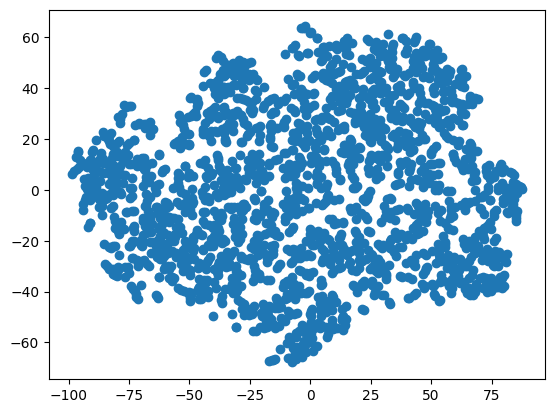

In [19]:
import matplotlib.pyplot as plt

plt.plot(X_embedded[:,0],X_embedded[:,1], "o")

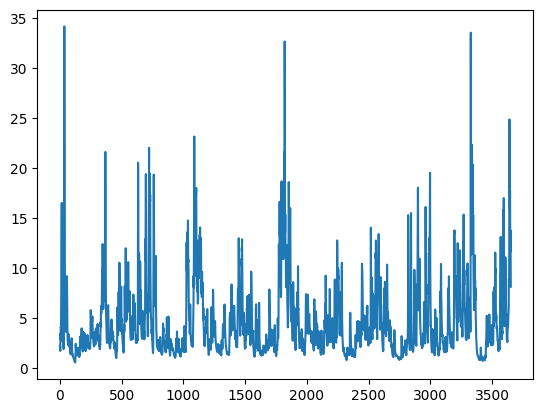

In [57]:
import matplotlib.pyplot as plt

plt.plot(test_metrics.detach().to("cpu").numpy()[999,:])

In [48]:
y_reshape = y.swapaxes(0,1).reshape(2055,-1)

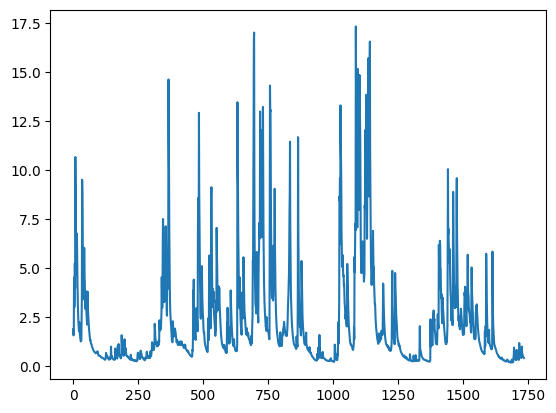

In [56]:
plt.plot(y_reshape.detach().to("cpu").numpy()[1000,:])